In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/kuldeepkumarjangir/stylegan1.git

fatal: destination path 'stylegan1' already exists and is not an empty directory.


In [ ]:
!git clone https://github.com/kuldeepkumarjangir/We_love_latent_space.git

fatal: destination path 'We_love_latent_space' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.insert(0,"/content/We_love_latent_space")
import dnnlib
import lib

In [ ]:
import tensorflow as tf
import pickle
import dnnlib.tflib as tflib
import os
import numpy as np
from lib.external.tf2_StyleGAN.stylegan import StyleGAN_G, copy_weights_to_keras_model

In [ ]:
tflib.init_tf()

model_folder = os.path.join(os.getcwd(), 'We_love_latent_space', 'Downloaded', 'StyleGAN_model', 'forward')

In [ ]:
# Load the previously saved weights
with open(os.path.join(model_folder, 'g_weights.pkl'), "rb") as f:
    g_weights = pickle.load(f)

In [ ]:
# Load the generator
generator = StyleGAN_G()
copy_weights_to_keras_model(generator.model_mapping, g_weights)
copy_weights_to_keras_model(generator.model_synthesis, g_weights)

.........Total number of parameters copied: 2101760
.......................................................................Total number of parameters copied: 24152419


In [ ]:
# Save generator weights
generator.save_weights(os.path.join(model_folder, 'Generator_cats.h5'))
print("Saved generator weights as h5!")

Saved generator weights as h5!


In [ ]:
# Libraries
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras

import lib.GAN as GAN
import lib.StyleGAN as StyleGAN

In [ ]:
# Training Parameters
batch_size = 2
steps_per_epoch = 1
epochs = 1
input_shape = (256, 256, 3)

# Define a list of parameter-sets, to attempt different recoder structures
parameters_dict = {
    'a': {
        'recoder_args': {
            'base_filters_n': 32,
            'filters_multiplier': 2,
            'n_layers': 6,
            'stride': 2,
            'kernel_size': 3,
            'extra_dense': True
         }
    },
}
recoder_attempt_name = 'a' # Chosen attempt
recoder_from_w = True # Whether to train towards w (if False towards Z)

In [ ]:
# Load StyleGAN
model_filepath_fwd = os.path.join(os.getcwd(), 'We_love_latent_space', 'Downloaded', 'StyleGAN_model', 'forward', 'Generator_cats')
stylegan = StyleGAN.load(model_filepath_fwd)

info = {
    'name': 'StyleGAN',
    'dataset': 'Cats'
}
latent_dim = stylegan.latent_dim

In [ ]:
# Recoder Training (Image->Z)
if not recoder_from_w:
    print("## Training recoder setup " + recoder_attempt_name)
    print("See summary of recoder for its structure. (Ignore discriminator and generator, they are not used.)")
    _, _, recoder = GAN.create(input_shape, latent_dim, **parameters_dict[recoder_attempt_name])
    model_filepath_bck = os.path.join(os.getcwd(), 'We_love_latent_space', 'Downloaded', 'StyleGAN_model',
                                      'backward_from_z_' + recoder_attempt_name, 'StyleGAN_Cats')
    GAN.train_inverse(input_shape, stylegan.latent_dim, model_filepath_bck, recoder,
                      lambda x: stylegan.generator(x, to_images=True, out_size=input_shape),
                      info=info, parameters=parameters_dict[recoder_attempt_name], batch_size=batch_size, steps_per_epoch=steps_per_epoch, epochs=epochs)
else:
# Recoder Training (Image->W)
    print("## Training recoder setup " + recoder_attempt_name)
    print("See summary of recoder for its structure. (Ignore discriminator and generator, they are not used.)")
    _, _, recoder = GAN.create(input_shape, latent_dim, **parameters_dict[recoder_attempt_name])
    model_filepath_bck = os.path.join(os.getcwd(), 'We_love_latent_space', 'Downloaded', 'StyleGAN_model',
                                      'backward_from_w_' + recoder_attempt_name, 'StyleGAN_Cats')
    sequence = StyleGAN.StyleGANWLatentGenerator(stylegan.generator.w_embedder, batch_size=batch_size,
                                                 latent_dim=latent_dim, batches_per_epoch=1000)
    GAN.train_inverse(input_shape, stylegan.latent_dim, model_filepath_bck, recoder,
                      lambda x: stylegan.generator.outputs_to_images(stylegan.generator.from_w(x), out_size=input_shape),
                      sequence=sequence,
                      info=info, parameters=parameters_dict[recoder_attempt_name], batch_size=batch_size, steps_per_epoch=steps_per_epoch, epochs=epochs)

## Training recoder setup a
See summary of recoder for its structure. (Ignore discriminator and generator, they are not used.)
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     6272      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       524544    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 256)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 512)       209

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 128)     6272      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 128, 128, 128)     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 256)       524544    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 64, 64, 256)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 512)       2097664   
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 512)     

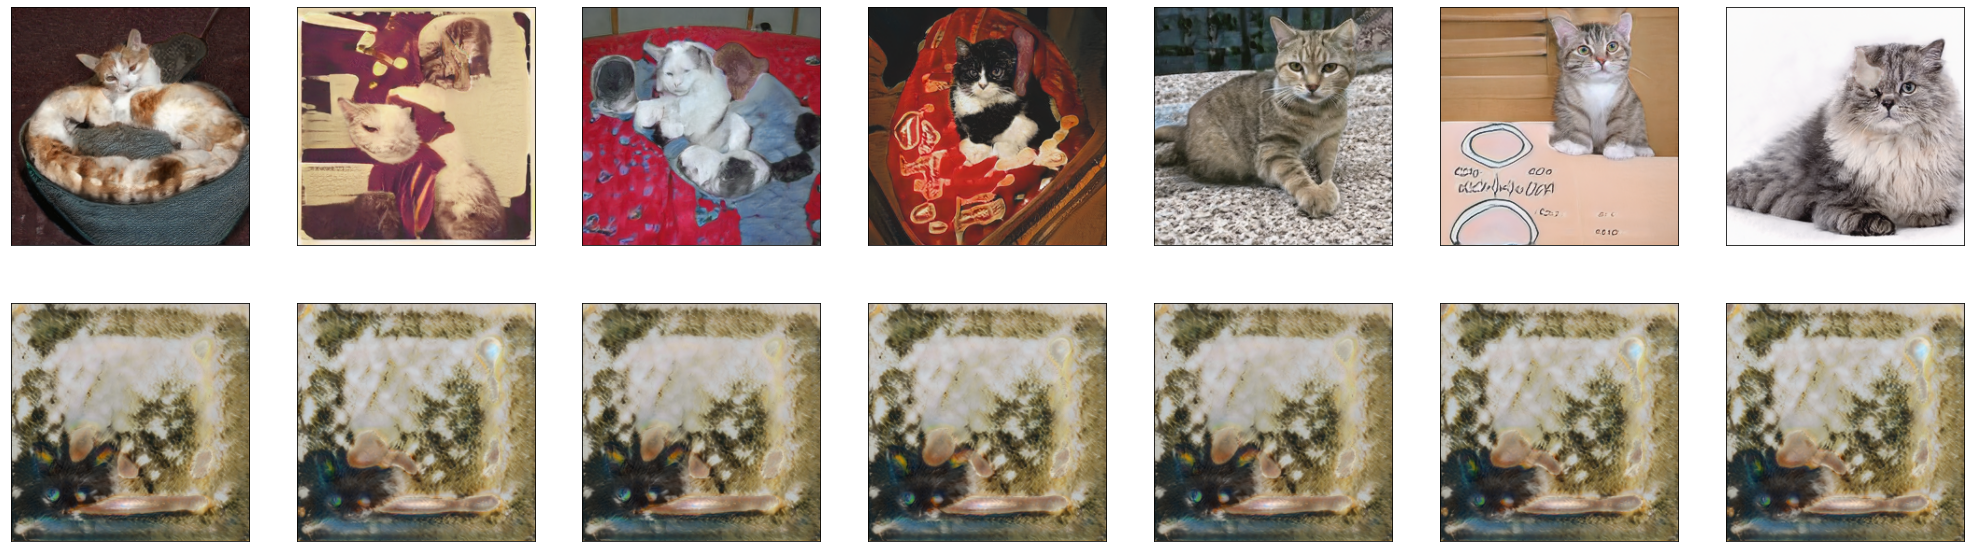

In [ ]:
# Recoder Reconstruction Test
n_imgs = 7
recoder_attempt_name = 'a'
recoder_from_w = True

model_filepath_fwd = os.path.join(os.getcwd(), 'We_love_latent_space', 'Downloaded', 'StyleGAN_model', 'forward', 'Generator_cats')
model_filepath_bck = os.path.join(os.getcwd(), 'We_love_latent_space', 'Downloaded', 'StyleGAN_model',
                                  'backward_' + ('from_w_' if recoder_from_w else '') + recoder_attempt_name, 'StyleGAN_Cats')

stylegan = StyleGAN.load(model_filepath_fwd)
igan = GAN.load_inverse(model_filepath_bck, stylegan)

random_latent_vectors = tf.random.normal((n_imgs, latent_dim))
start_images_recode = stylegan.generator(random_latent_vectors, to_images=True, out_size=input_shape)
start_images = (start_images_recode + 1) / 2
if not recoder_from_w:
    random_latent_predicted = igan.recoder(start_images_recode)
    end_images = stylegan.generator(random_latent_predicted, to_images=True, out_size=input_shape, to_zero_one=True)
else:
    random_w_predicted = igan.recoder(start_images_recode)
    end_images = stylegan.generator.outputs_to_images(stylegan.generator.from_w(random_w_predicted), out_size=input_shape,
                                                      to_zero_one=True)
                                
plt.figure(figsize=(5*n_imgs, 5*2))
for k in range(n_imgs):
    img = keras.preprocessing.image.array_to_img(start_images[k])
    plt.subplot(2, n_imgs, k+1)
    plt.xticks([])  
    plt.yticks([])
    plt.imshow(img)
    img = keras.preprocessing.image.array_to_img(end_images[k])
    plt.subplot(2, n_imgs, n_imgs+k+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)  
plt.show()